# Query 1

0. Exact Result
1. Stratifed sampling
2. 2D-KDE
3. Regression models and KDE
4. Weighted KDE
5. Further exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion


from scipy.stats import gaussian_kde
from collections import Counter

import scipy
from scipy import integrate
import timeit
import pickle
from datetime import date, timedelta
import sys
import scipy.stats as st
from random import random
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.functions import col

from pyspark import broadcast
# To avoid OverflowError: cannot serialize a string larger than 4GiB
def broadcast_dump(self, value, f):
    pickle.dump(value, f, 4)  # was 2, 4 is first protocol supporting >4GB
    f.close()
    return f.name
broadcast.Broadcast.dump = broadcast_dump

conf = pyspark.SparkConf().setMaster("local[16]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','12g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [40]:
lineitem = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/lineitem.parquet")

In [5]:
LEFT_DATE = date(1998, 12, 1) - timedelta(days = 2000)
RIGHT_DATE = date(1998, 12, 1) + timedelta(days = 2000)

# 0. Exact Result

In [29]:
def compute_exact_result(lineitem, left_date, right_date):
    return lineitem.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
            .groupby("l_returnflag", "l_linestatus")\
            .agg(f.sum('l_quantity').alias('sum_qty'), f.sum('l_extendedprice').alias('sum_base_price'), \
                 f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('sum_disc_price'),\
                 f.sum(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('sum_charge'),\
                 f.avg("l_quantity").alias('avg_qty'), f.avg('l_extendedprice').alias('avg_price'), \
                 f.avg('l_discount').alias('avg_disc'), f.count('*').alias('count_order') )\
            .sort("l_returnflag", "l_linestatus")

start = timeit.default_timer()
exact_result = compute_exact_result(lineitem, LEFT_DATE, RIGHT_DATE)
exact_result.show()
stop = timeit.default_timer()
print('Execution time of exact result:', stop - start)

+------------+------------+---------+--------------+--------------+----------------+---------+------------+--------+-----------+
|l_returnflag|l_linestatus|  sum_qty|sum_base_price|sum_disc_price|      sum_charge|  avg_qty|   avg_price|avg_disc|count_order|
+------------+------------+---------+--------------+--------------+----------------+---------+------------+--------+-----------+
|           A|           F| 37327.00|   56204523.56| 53394327.3825| 55452285.086891|25.461801|38338.692742|0.050300|       1466|
|           N|           F|  1852.00|    2839903.89|  2719994.3983|  2822487.704927|26.457143|40570.055571|0.047429|         70|
|           N|           O|130564.00|  196084910.69|186356186.7909|193935904.883875|25.696516|38591.795058|0.050264|       5081|
|           R|           F| 37455.00|   55763795.97| 52976712.3400| 55132177.830708|25.549113|38038.060007|0.049905|       1466|
+------------+------------+---------+--------------+--------------+----------------+---------+---

### Helper Functions

In [6]:
def calculate_error(Q1_approx, Q1_exact):
    df_2 = Q1_approx.toPandas().set_index(['l_returnflag', 'l_linestatus']).astype(float)
    df_1 = Q1_exact.toPandas().set_index(['l_returnflag', 'l_linestatus']).astype(float)
    return abs(df_2 - df_1) * 100 / df_1

def calculate_size_of(obj):
    p = pickle.dumps(obj)
    size = sys.getsizeof(p)
    print('The size of the object in MB: ', size / 2 ** 20)
    return size

In [7]:
CONSTRUCTION_TIME = [0] * 4
EXECUTION_TIME = [0] * 4
SPACE = [0] * 4
ERROR = [0] * 4

# Query 1

# 1. Sampling-based

## Construction

In [22]:
def magic_K_search(dfAgg, aggColumn, z, error_bound):
    minStrataSize = 2.0
    maxStrataSize = dfAgg.agg(f.max("count(" + aggColumn + ")")).first()[0]
    
    magicK = 0.0; sampleSize = 0.0
    
    # use bisection to find the best (minimum) K
    while (minStrataSize + 1 < maxStrataSize):
        mid = (minStrataSize + maxStrataSize) // 2
        print("maxStrataSize: ", maxStrataSize, "minStrataSize: ", minStrataSize, "midStrataSize: ", mid)

        v_by_n = dfAgg.rdd.map(lambda row: cal_v_by_n(row, mid)).sum()
        estimatedError = np.sqrt(v_by_n) * z
        print("Estimated error with bisection: ", estimatedError, "User defined error bound", error_bound)
        if estimatedError <= error_bound:
            maxStrataSize = mid
        else:
            minStrataSize = mid
      
    if np.sqrt(dfAgg.rdd.map(lambda row: cal_v_by_n(row, minStrataSize)).sum()) * z <= error_bound:
        magicK = minStrataSize
    elif np.sqrt(dfAgg.rdd.map(lambda row: cal_v_by_n(row, minStrataSize)).sum()) * z <= error_bound:
        magicK = maxStrataSize
    else:
    # the required K can't be found
        print("The required K can't be found")
    return magicK

def cal_v_by_n(row, K):
    stratumSampleSize = row[0] if row[0] < K else K
    error = np.power(row[0], 2) * row[1] / stratumSampleSize
    return error

In [48]:
def ScaSRS(stra_block, K): 
    sigma = 0.00005
    stratumSize, stratum = len(stra_block[1]), stra_block[1]

    if stratumSize <= K:
        return stratum
    
    p = K / stratumSize
    gamma1 = -1.0 * (np.log(sigma) / stratumSize)
    gamma2 = -1.0 * (2 * np.log(sigma) / 3 / stratumSize)
    q1 = min(1, p + gamma1 + np.sqrt(gamma1 * gamma1 + 2 * gamma1 * p))
    q2 = max(0, p + gamma2 - np.sqrt(gamma2 * gamma2 + 3 * gamma2 * p))

    l = 0
    waitlist, res = [], []

    for nextRow in stratum:
        Xj = random()
        if Xj < q2:
            res.append(nextRow)
            l += 1
        elif Xj < q1:
            waitlist.append((Xj, nextRow))

    # select the smallest pn-l items from waitlist
    waitlist.sort()
    if int(K - l) > 0:
        res += [item[1] for item in waitlist[:int(K-l)]]
    return res

In [49]:
def generate_stratified_sample(QCS, e, ci):
    z = st.norm.ppf(ci)
    aggColumn = "l_extendedprice"
    error_bound = float(lineitem.agg(f.sum(aggColumn)).first()[0])
    dfAgg = lineitem.groupBy(QCS).agg(f.count(aggColumn), f.var_pop(aggColumn))\
            .select("count(" + aggColumn + ")", "var_pop(" + aggColumn + ")")
    magicK = magic_K_search(dfAgg, aggColumn, z, error_bound)
    stratifiedSample = lineitem.rdd.map(lambda row: ('_'.join([str(row[each]) for each in QCS]), row))\
                        .groupByKey().flatMap(lambda stra_block: ScaSRS(stra_block, magicK))
    sampleDF = stratifiedSample.toDF()
    return sampleDF

## Testing

In [24]:
def compute_approximate_result(lineitem_sample, count_df, left_date, right_date):
    count_df_ = count_df.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
                       .groupby('l_returnflag', 'l_linestatus').agg(f.sum('count').alias('count_order'))
    
    lineitem_avg = lineitem_sample.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
            .groupby("l_returnflag", "l_linestatus")\
            .agg(f.avg(col('l_extendedprice') * (1 - col('l_discount'))).alias('avg_disc_price'),\
                 f.avg(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('avg_charge'),\
                 f.avg("l_quantity").alias('avg_qty'), f.avg('l_extendedprice').alias('avg_price'), \
                 f.avg('l_discount').alias('avg_disc'))\
           .join(count_df_, ["l_returnflag", "l_linestatus"])
    
    return lineitem_avg.withColumn('sum_qty', f.col('avg_qty') * f.col('count_order') )\
                .withColumn('sum_base_price', f.col('avg_price') * f.col('count_order') )\
                .withColumn('sum_disc_price', f.col('avg_disc_price') * f.col('count_order'))\
                .withColumn('sum_charge', f.col('avg_charge') * f.col('count_order'))\
            .select(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])


## Execution
### Construction time

In [53]:
QCS = ['l_returnflag', 'l_linestatus', 'l_shipdate']
e, ci = 0.01, 0.99

start = timeit.default_timer()
sampleDF = generate_stratified_sample(QCS, e, ci).cache(); sampleDF.count()
count_df = lineitem.groupby("l_returnflag", "l_linestatus", 'l_shipdate').count()
stop = timeit.default_timer()
EXECUTION_TIME[0] = stop - start
print("Construction time of stratified-sampling-based method is ", stop - start)

sampleDF.write.parquet('./pickles/sampleDF')
count_df.write.parquet('./pickles/countDF')

### Space

In [54]:
SPACE[0] = calculate_size_of(sampleDF.toPandas()) + calculate_size_of(count_df.toPandas())

The size of the object in MB:  2.7416296005249023
The size of the object in MB:  0.1352987289428711


### Execution Time

In [64]:
start = timeit.default_timer()
sample_based_result = compute_approximate_result(sampleDF, count_df, LEFT_DATE, RIGHT_DATE)
sample_based_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[0] = stop - start
print('Execution time of stratified-sampling-based method:', stop - start)

+------------+------------+---------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-----------+
|l_returnflag|l_linestatus|        sum_qty|     sum_base_price|     sum_disc_price|         sum_charge|             avg_qty|           avg_price|            avg_disc|count_order|
+------------+------------+---------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-----------+
|           N|           F|  920839.800000|  1458617334.055000|  1386682778.716010|  1445756848.963148|23.70000000000000...|37540.98250000000...|0.047833333333333...|      38854|
|           A|           F|23805978.975577| 35819333960.181791| 34046623953.602258| 35407193723.080634|26.41451831750339...|39744.23626865671...|0.049430122116689...|     901246|
|           N|           O|76924855.769596|115163536368.889050|109290188586.672354|113644650122.641308|25

### Relative Error Rate

In [56]:
sample_based_error = calculate_error(sample_based_result, exact_result)
sample_based_error

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                             
A            F             3.479030        3.825740        3.873375   
N            F             7.118821        1.942002        1.868213   
             O             0.380170        0.198656        0.092130   
R            F             0.054085        0.112414        0.113429   

                           sum_charge   avg_qty  avg_price  avg_disc  \
l_returnflag l_linestatus                                              
A            F               3.869245  3.479028   3.825740  1.022963   
N            F               1.625720  7.118821   1.942002  4.510943   
             O               0.073640  0.380169   0.198656  1.361837   
R            F               0.167344  0.054087   0.112414  0.042279   

                           count_order  
l_returnflag l_linestatus               
A            F                     0.0  
N            F                     0.0  
             O                     0.0  
R            F                     0.0

In [57]:
ERROR[0] = (sample_based_error.mean().mean(), sample_based_error.mean().std())

In [58]:
ERROR[0]

(1.651342309290882, 0.8695094417792658)

# 2. 2D-KDE

## 2.0. Cleaning and Normalization

In [41]:
lineitem_clean = lineitem.withColumn('l_shipdate', f.to_date('l_shipdate', 'yyyy-MM-dd'))
lineitem_schema = dict(zip(lineitem_clean.schema.names, range(len(lineitem_clean.schema.names))))

for col_name in lineitem.schema.names[:8]:
    lineitem_clean = lineitem_clean.withColumn(col_name, col(col_name).cast('float'))

In [42]:
# transform = lambda x, avg, stddev: (x - avg)/stddev
# i_transform = lambda x, avg, stddev: x * stddev + avg
transform, i_transform = {}, {}
normalize = {}

START_DATE = lineitem_clean.select(f.min('l_shipdate')).first()[0]
END_DATE = lineitem_clean.select(f.max('l_shipdate')).first()[0]
normalize['date'] = (START_DATE, END_DATE)
def lambda_normalize_date(x):
    transformed_date = -1 + 2 * (x - normalize['date'][0]).days / (normalize['date'][1] - normalize['date'][0]).days
    if transformed_date < -1: return -1
    elif transformed_date > 1: return 1
    else: return transformed_date
transform['date'] = lambda_normalize_date

MIN_QUANTITY = lineitem_clean.select(f.min('l_quantity')).first()[0]
MAX_QUANTITY = lineitem_clean.select(f.max('l_quantity')).first()[0]
normalize['quantity'] = (MIN_QUANTITY, MAX_QUANTITY)
transform['quantity'] = lambda x: -1 + 2 * (x - normalize['quantity'][0])/(normalize['quantity'][1] - normalize['quantity'][0])
i_transform['quantity'] = lambda x: 0.5 * (x + 1) * (normalize['quantity'][1] - normalize['quantity'][0]) + normalize['quantity'][0]

avg = lineitem_clean.select(f.avg('l_extendedprice')).first()[0]
stddev = lineitem_clean.select(f.stddev('l_extendedprice')).first()[0]
normalize['price'] = (avg, stddev)
transform['price'] = lambda x: (x - normalize['price'][0])/normalize['price'][1]
i_transform['price'] = lambda x: x * normalize['price'][1] + normalize['price'][0]

avg = lineitem_clean.select(f.avg('l_discount')).first()[0]
stddev = lineitem_clean.select(f.stddev('l_discount')).first()[0]
normalize['disc'] = (avg, stddev)
transform['disc'] = lambda x: (x - normalize['disc'][0])/normalize['disc'][1]
i_transform['disc'] = lambda x: x * normalize['disc'][1] + normalize['disc'][0]

In [43]:
transform['price'](lineitem_clean.select(f.max('l_extendedprice')).first()[0])
transform['price'](lineitem_clean.select(f.max(f.col('l_extendedprice') * (1 - f.col('l_discount')))).first()[0])
transform['price'](lineitem_clean.select(f.max(f.col('l_extendedprice') * (1 - f.col('l_discount')) * (1 + f.col('l_tax')))).first()[0])

3.174031328373099

In [44]:
transform['price'](lineitem_clean.select(f.min('l_extendedprice')).first()[0])
transform['price'](lineitem_clean.select(f.min(f.col('l_extendedprice') * (1 - f.col('l_discount')))).first()[0])
transform['price'](lineitem_clean.select(f.min(f.col('l_extendedprice') * (1 - f.col('l_discount')) * (1 + f.col('l_tax')))).first()[0])

-1.6064388291501948

In [45]:
transform['date'](lineitem_clean.select(f.max('l_shipdate')).first()[0])

1.0

## 2.1. KDE Construction

In [46]:
def compute_kdes(s_values):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    
    kdes_bank = dict()
    
    # Training Data
    X_shipdate = []
    X_quantity = []
    X_price = []
    X_disc = []
    X_price_disc = []
    X_price_disc_tax = []
    
    # Fill in the training data
    for row in iterable_rows:
        X_shipdate.append(transform['date'](row['l_shipdate']))
#         X_quantity.append(transform['quantity'](row['l_quantity']))
#         X_price.append(transform['price'](row['l_extendedprice']))
#         X_disc.append(transform['disc'](row['l_discount']))
#         X_price_disc.append(transform['price'](row['l_extendedprice'] * (1 - row['l_discount'])))
#         X_price_disc_tax.append(transform['price'](row['l_extendedprice'] * (1 - row['l_discount']) * (1 + row['l_tax'])))

        X_quantity.append(transform['quantity'](row['l_quantity']))
        X_price.append(transform['price'](row['l_extendedprice']))
        X_disc.append(transform['disc'](row['l_discount']))
        X_price_disc.append(transform['price'](row['l_extendedprice'] * (1 - row['l_discount'])))
        X_price_disc_tax.append(transform['price'](row['l_extendedprice'] * (1 - row['l_discount']) * (1 + row['l_tax'])))
        
    
    # Store the trained model into the KDE bank
    kdes_bank['n'] = len(iterable_rows)
    kdes_bank['quantity'] = gaussian_kde( [X_shipdate, X_quantity], bw_method='scott')
    kdes_bank['price'] = gaussian_kde( [X_shipdate, X_price], bw_method='scott')
    kdes_bank['disc'] = gaussian_kde( [X_shipdate, X_disc], bw_method='scott')
    kdes_bank['disc_price'] = gaussian_kde( [X_shipdate, X_price_disc], bw_method='scott')
    kdes_bank['charge'] = gaussian_kde( [X_shipdate, X_price_disc_tax], bw_method='scott')
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, kdes_bank]

In [47]:
def kde_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus']]), row)).groupByKey()\
        .map(lambda str_rows: compute_kdes(str_rows) )
    # (RDD) strat_kde: flag, status, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    # The last two items are: stratum_str(-2), kdes_bank(-1)
    
    strata_catalogue = strat_kde.map(lambda row: row[:3]).toDF(["l_returnflag", "l_linestatus", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

### Construction time

In [49]:
start = timeit.default_timer()
strata_catalogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
strata_catalogue = strata_catalogue.cache(); strata_catalogue.show()
stop = timeit.default_timer()
CONSTRUCTION_TIME[1] = stop - start
print('Construction time is', stop - start)

### Space

In [ ]:
SPACE[1] = calculate_size_of(strata_catalogue.toPandas()) + calculate_size_of(hashMap_kde)

#### Uptil now the construction phas is completed. To be stored are two main objects (hashMap_kde and strata_catalouge) and normalization paramters. 
All these is done in the big database in Spark.

---

#### As below is to compute the results with KDE locally with Pandas DF and KDE of sk-learn

In [34]:
def kde_based_cal_result(row, left_date, right_date):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    x_left, x_right = transform['date'](left_date), transform['date'](right_date)
    kde_bank = hashMap_kde[row['stratum_str']]
    
    i2 = kde_bank['quantity'].integrate_box([x_left, -np.inf], [x_right, np.inf])
    count_order = kde_bank['n'] * i2
    
    i1 = integrate.dblquad(lambda x, y: i_transform['quantity'](y) * kde_bank['quantity'].evaluate([x, y]), -np.inf, np.inf, x_left, x_right)
    avg_qty = i1[0] / i2
    sum_qty = avg_qty * count_order
    
    i1 = integrate.dblquad(lambda x, y: i_transform['price'](y) * kde_bank['price'].evaluate([x, y]),  -np.inf, np.inf, x_left, x_right)
#     i2 = kde_bank['price'].integrate_box([x_left, -2], [x_right, 3])
    avg_price = i1[0] / i2
    sum_base_price = avg_price * count_order
    
    i1 = integrate.dblquad(lambda x, y: i_transform['disc'](y) * kde_bank['disc'].evaluate([x, y]),  -np.inf, np.inf, x_left, x_right)
#     i2 = kde_bank['disc'].integrate_box([x_left, -2], [x_right, 2])
    avg_disc = i1[0] / i2
    
    i1 = integrate.dblquad(lambda x, y: i_transform['price'](y) * kde_bank['disc_price'].evaluate([x, y]), -np.inf, np.inf, x_left, x_right)
#     i2 = kde_bank['disc_price'].integrate_box([x_left, -2], [x_right, 3])
    sum_disc_price = (i1[0] / i2) * count_order
                      
    i1 = integrate.dblquad(lambda x, y: i_transform['price'](y) * kde_bank['charge'].evaluate([x, y]),  -np.inf, np.inf, x_left, x_right)
#     i2 = kde_bank['charge'].integrate_box([x_left, -2], [x_right, 3.2])
    sum_charge = (i1[0] / i2) * count_order
                           
    return (row['l_returnflag'], row['l_linestatus'], sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order)


In [35]:
def kde_based_method_testing(strata_catalogue, hashMap_kde, left_date, right_date):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    Q1_kde_approx = strata_catalogue.rdd.map(lambda x: kde_based_cal_result(x, left_date, right_date))\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_kde_approx


### Execution Time

In [36]:
start = timeit.default_timer()
twod_kde_result = kde_based_method_testing(strata_catalogue, hashMap_kde, LEFT_DATE, RIGHT_DATE).cache()
twod_kde_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[1] = stop - start
print('Execution time of 2-D KDE methods is ', stop - start)

+------------+------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|l_returnflag|l_linestatus|           sum_qty|      sum_base_price|      sum_disc_price|          sum_charge|           avg_qty|         avg_price|            avg_disc|       count_order|
+------------+------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|           A|           F| 37381.65257125477| 5.629227123995184E7|5.3474329970373556E7| 5.555162464870172E7|25.424586336205056| 38286.36809122182|0.050317933018991325|1470.2954092127209|
|           N|           F|1852.0000001886349|    2839903.90039074|  2719994.4082553396|  2822487.7143758987|26.457142859837685| 40570.05571986778|0.047428597724621886| 69.99999999999989|
|           N|           O|128911.91098020304|1.936510808318

### Error

In [37]:
twod_kde_error = calculate_error(twod_kde_result, exact_result)
twod_kde_error

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                                 
A            F             1.464157e-01    1.561221e-01    1.498335e-01   
N            F             1.018547e-08    3.658835e-07    3.660059e-07   
             O             1.265348e+00    1.241212e+00    1.239617e+00   
R            F             4.351594e-01    4.616723e-01    4.513703e-01   

                             sum_charge       avg_qty     avg_price  avg_disc  \
l_returnflag l_linestatus                                                       
A            F             1.791442e-01  1.461588e-01  1.364800e-01  0.035652   
N            F             3.347720e-07  5.297712e-07  3.669400e-07  0.000848   
             O             1.245175e+00  2.533929e-02  4.978894e-02  0.048417   
R            F             4.457806e-01  3.322562e-01  3.587973e-01  0.080212   

                            count_order  
l_returnflag l_linestatus                
A            F             2.930020e-01  
N            F             1.624098e-13  
             O             1.290359e+00  
R            F             1.032454e-01

In [39]:
ERROR[1] = (twod_kde_error.mean().mean(), twod_kde_error.mean().std())
ERROR[1] 

(0.3224190054102141, 0.18587604180638273)

---
# 3. Regression-based KDE

## Construction

In [19]:
def compute_regressions(s_values, bw='scott'):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    
    regression_bank = dict()
    
    # Training Data
    X_shipdate = []
    X_quantity = []
    X_price = []
    X_disc = []
    X_price_disc = []
    X_price_disc_tax = []
    count_order = 0
    
    # Fill in the training data
    for row in iterable_rows:
        X_shipdate.append(transform['date'](row['l_shipdate']))
        X_quantity.append(row['avg_qty'])
        X_price.append(row['avg_base_price'])
        X_disc.append(row['avg_disc'])
        X_price_disc.append(row['avg_disc_price'])
        X_price_disc_tax.append(row['avg_charge'])
        count_order += row['count_order']
    
    # Store the trained model into the KDE bank
    regression_bank['n'] = count_order
    regression_bank['date'] = gaussian_kde(X_shipdate, bw_method=bw)
    regression_bank['quantity'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_quantity).reshape(-1, 1))
    regression_bank['price'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_price).reshape(-1, 1))
    regression_bank['disc'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_disc).reshape(-1, 1))
    regression_bank['disc_price'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_price_disc).reshape(-1, 1))
    regression_bank['charge'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_price_disc_tax).reshape(-1, 1))
    
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, regression_bank]

In [20]:
def regression_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.groupby('l_returnflag', 'l_linestatus', 'l_shipdate')\
            .agg(f.avg('l_quantity').alias('avg_qty'), f.avg('l_extendedprice').alias('avg_base_price'), \
                 f.avg(col('l_extendedprice') * (1 - col('l_discount'))).alias('avg_disc_price'),\
                 f.avg(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('avg_charge'),\
                 f.avg('l_discount').alias('avg_disc'), f.count('*').alias('count_order') ).rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus']]), row)).groupByKey()\
        .map(compute_regressions)
    # (RDD) strat_kde: flag, status, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    # The last two items are: stratum_str(-2), kdes_bank(-1)
    
    strata_catalogue = strat_kde.map(lambda row: row[:3]).toDF(["l_returnflag", "l_linestatus", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

### Construction time

In [21]:
start = timeit.default_timer()
strata_catalogue, hashMap_reg = regression_based_method_construction(lineitem_clean)
strata_catalogue = strata_catalogue.cache(); strata_catalogue.show()
stop = timeit.default_timer()
CONSTRUCTION_TIME[2] = stop - start
print('Construction time is', stop - start)

+------------+------------+-----------+
|l_returnflag|l_linestatus|stratum_str|
+------------+------------+-----------+
|           R|           F|        R_F|
|           N|           F|        N_F|
|           N|           O|        N_O|
|           A|           F|        A_F|
+------------+------------+-----------+

Construction time is 11.201938771999977


### Space

In [22]:
SPACE[2] = calculate_size_of(strata_catalogue.toPandas()) + calculate_size_of(hashMap_reg)

The size of the object in MB:  0.0008783340454101562
The size of the object in MB:  0.5554733276367188


## Testing

In [23]:
def regression_based_cal_result(row, left_date, right_date):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    
    regression_bank = hashMap_reg[row['stratum_str']]
    
    x_left, x_right = transform['date'](left_date), transform['date'](right_date)
    i1 = integrate.quad(lambda x: regression_bank['quantity'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    i2 = integrate.quad(lambda x: regression_bank['date'].evaluate(x), x_left, x_right)
    avg_qty = i1[0] / i2[0]
    count_order = regression_bank['n'] * i2[0]
    sum_qty = avg_qty * count_order
    
    i1 = integrate.quad(lambda x: regression_bank['price'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    avg_price = i1[0] / i2[0]
    sum_base_price = avg_price * count_order
    
    i1 = integrate.quad(lambda x: regression_bank['disc'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    avg_disc = i1[0] / i2[0]
    
    i1 = integrate.quad(lambda x: regression_bank['disc_price'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    sum_disc_price = (i1[0] / i2[0]) * count_order
                      
    i1 = integrate.quad(lambda x: regression_bank['charge'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    sum_charge = (i1[0] / i2[0]) * count_order
                           
    return (row['l_returnflag'], row['l_linestatus'], sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order)


In [24]:
def regression_based_method_testing(strata_catalogue, left_date, right_date):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    Q1_reg_approx = strata_catalogue.rdd.map(lambda x: regression_based_cal_result(x, left_date, right_date))\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_reg_approx

### Execution time

In [25]:
start = timeit.default_timer()
Q1_reg_approx = regression_based_method_testing(strata_catalogue, LEFT_DATE, RIGHT_DATE).cache()
Q1_reg_approx.show()
stop = timeit.default_timer()
EXECUTION_TIME[2] = stop - start
print('Execution time:', stop - start)

+------------+------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|l_returnflag|l_linestatus|            sum_qty|      sum_base_price|      sum_disc_price|          sum_charge|           avg_qty|         avg_price|            avg_disc|       count_order|
+------------+------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|           A|           F|2.210539933529191E7|3.299575297030004...|3.135901388918444...|3.261940956056857E10|25.619207777132807| 38240.65959122837| 0.04981617246229237| 862844.7658331867|
|           N|           F|  992242.8236287098|1.4875430567616413E9|1.4131345901494753E9|1.4694169312326741E9| 25.53772645361378|38285.454696083834| 0.04988557316154054|           38854.0|
|           N|           O| 7.44514116487584E7|1.116911

### Error

In [26]:
regression_based_error = calculate_error(Q1_reg_approx, exact_result)

In [27]:
ERROR[2] = (regression_based_error.mean().mean(), regression_based_error.mean().std())

# 4. Weighted-KDE

In [27]:
lineitem_clean = lineitem.withColumn('l_shipdate', f.to_date('l_shipdate', 'yyyy-MM-dd'))
lineitem_schema = dict(zip(lineitem_clean.schema.names, range(len(lineitem_clean.schema.names))))

for col_name in lineitem.schema.names[:8]:
    lineitem_clean = lineitem_clean.withColumn(col_name, col(col_name).cast('float'))

In [28]:
transform, i_transform = {}, {}
normalize = {}

START_DATE = lineitem_clean.select(f.min('l_shipdate')).first()[0]
END_DATE = lineitem_clean.select(f.max('l_shipdate')).first()[0]
normalize['date'] = (START_DATE, END_DATE)
def lambda_normalize_date(x):
    transformed_date = -1 + 2 * (x - normalize['date'][0]).days / (normalize['date'][1] - normalize['date'][0]).days
    if transformed_date < -1: return -1
    elif transformed_date > 1: return 1
    else: return transformed_date
transform['date'] = lambda_normalize_date

In [29]:
def compute_kdes(s_values, bw='scott'):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    kdes_bank = dict()
    
    # Training Data
    X_shipdate = []
    X_quantity = []
    X_price = []
    X_disc = []
    X_price_disc = []
    X_price_disc_tax = []
    X_count = []
    
    # Fill in the training data
    for row in iterable_rows:
        X_shipdate.append(transform['date'](row['l_shipdate']))
        X_quantity.append(row['sum_qty'])
        X_price.append(row['sum_base_price'])
        X_disc.append(row['sum_disc'])
        X_price_disc.append(row['sum_disc_price'])
        X_price_disc_tax.append(row['sum_charge'])
        X_count.append(row['count_order'])
        
    # Store the trained model into the KDE bank
    kdes_bank['quantity'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_quantity)
    kdes_bank['quantity_sum'] = np.sum(X_quantity)
    kdes_bank['price'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_price)
    kdes_bank['price_sum'] = np.sum(X_price)
    kdes_bank['disc'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_disc)
    kdes_bank['disc_sum'] = np.sum(X_disc)
    kdes_bank['disc_price'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_price_disc)
    kdes_bank['disc_price_sum'] = np.sum(X_price_disc)
    kdes_bank['charge'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_price_disc_tax)
    kdes_bank['charge_sum'] = np.sum(X_price_disc_tax)
    kdes_bank['count'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_count)
    kdes_bank['count_sum'] = np.sum(X_count)
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, kdes_bank]

In [30]:
def kde_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.groupby('l_returnflag', 'l_linestatus', 'l_shipdate')\
            .agg(f.sum('l_quantity').alias('sum_qty'), f.sum('l_extendedprice').alias('sum_base_price'), \
                 f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('sum_disc_price'),\
                 f.sum(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('sum_charge'),\
                 f.sum('l_discount').alias('sum_disc'), f.count('*').alias('count_order') ).rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus']]), row)).groupByKey()\
        .map(compute_kdes)
    # (RDD) strat_kde: flag, status, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    # The last two items are: stratum_str(-2), kdes_bank(-1)
    
    strata_catalogue = strat_kde.map(lambda row: row[:3]).toDF(["l_returnflag", "l_linestatus", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

### Construction

In [31]:
start = timeit.default_timer()
strata_catalogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
strata_catalogue = strata_catalogue.cache(); strata_catalogue.show()
stop = timeit.default_timer()
CONSTRUCTION_TIME[3] = stop - start
print(stop - start)

+------------+------------+-----------+
|l_returnflag|l_linestatus|stratum_str|
+------------+------------+-----------+
|           R|           F|        R_F|
|           N|           F|        N_F|
|           N|           O|        N_O|
|           A|           F|        A_F|
+------------+------------+-----------+

6.000090865999937


### Space

In [32]:
SPACE[3] = calculate_size_of(strata_catalogue.toPandas()) + calculate_size_of(hashMap_kde)

The size of the object in MB:  0.0008783340454101562
The size of the object in MB:  0.3635749816894531


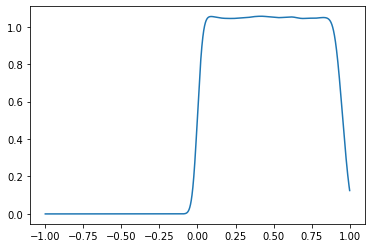

In [33]:
kde = hashMap_kde['N_O']['quantity']
kde.set_bandwidth(.1)
plt.plot(np.linspace(-1, 1, 10000), kde.evaluate(np.linspace(-1, 1, 10000)))

## Testing

In [34]:
def kde_based_cal_result(row, l_date, r_date, bw):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    x_left, x_right = transform['date'](l_date), transform['date'](r_date)
    kde_bank = hashMap_kde[row['stratum_str']]
    
    kde_count = kde_bank['count']; kde_count.set_bandwidth(bw)
    count_order = kde_bank['count_sum'] * kde_count.integrate_box_1d(x_left, x_right)
    
    kde_quantity = kde_bank['quantity']; kde_quantity.set_bandwidth(bw)
    sum_qty = kde_bank['quantity_sum'] * kde_quantity.integrate_box_1d(x_left, x_right)
    avg_qty = sum_qty / count_order
    
    kde_price = kde_bank['price']; kde_price.set_bandwidth(bw)
    sum_base_price = kde_bank['price_sum'] * kde_price.integrate_box_1d(x_left, x_right)
    avg_price = sum_base_price / count_order
    
    kde_disc = kde_bank['disc']; kde_disc.set_bandwidth(bw)
    avg_disc = kde_bank['disc_sum'] * kde_disc.integrate_box_1d(x_left, x_right) / count_order
    
    kde_disc_price = kde_bank['disc_price']; kde_disc_price.set_bandwidth(bw)
    sum_disc_price = kde_bank['disc_price_sum'] * kde_disc_price.integrate_box_1d(x_left, x_right)
    
    kde_charge = kde_bank['charge']; kde_charge.set_bandwidth(bw)
    sum_charge = kde_bank['charge_sum'] * kde_charge.integrate_box_1d(x_left, x_right)
                           
    return (row['l_returnflag'], row['l_linestatus'], float(sum_qty), float(sum_base_price), float(sum_disc_price),\
            float(sum_charge), float(avg_qty), float(avg_price), float(avg_disc), float(count_order))

In [35]:
def kde_based_method_testing(strata_catalogue, l_date, r_date, bw):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    Q1_kde_approx = strata_catalogue.rdd.map(lambda x: kde_based_cal_result(x, l_date, r_date, bw))\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_kde_approx

### Execution

In [36]:
start = timeit.default_timer()
weighed_kde_result = kde_based_method_testing(strata_catalogue, LEFT_DATE, RIGHT_DATE, .1).cache(); weighed_kde_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[3] = stop - start
print('Execution time is', stop - start)

+------------+------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|l_returnflag|l_linestatus|             sum_qty|      sum_base_price|      sum_disc_price|          sum_charge|           avg_qty|         avg_price|            avg_disc|       count_order|
+------------+------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+
|           A|           F|2.2985573547232825E7|3.446974444214384...|3.274872018013493...|3.405865751535168E10| 25.52503570948192| 38277.98579724191|0.049941529002023546| 900510.9261686264|
|           N|           F|            991417.0| 1.487504710632202E9|1.4130821665253906E9|1.4696492054312134E9|25.516471920522985|38284.467767339316|0.050093426752791215|           38854.0|
|           N|           O| 7.646623083666696E7|1.

### Error

In [37]:
weighted_kde_error = calculate_error(weighed_kde_result, exact_result)
ERROR[3] = (weighted_kde_error.mean().mean(), weighted_kde_error.mean().std())

In [38]:
weighted_kde_error.mean()

sum_qty           0.097679
sum_base_price    0.097632
sum_disc_price    0.097720
sum_charge        0.097802
avg_qty           0.002119
avg_price         0.001852
avg_disc          0.000890
count_order       0.096923
dtype: float64

In [24]:
CONSTRUCTION_TIME

[0, 0, 0, 6.882161676999999]

In [25]:
EXECUTION_TIME

[0, 0, 0, 2.4430036059999907]

In [26]:
ERROR

[0, 0, 0, (0.061577356121153705, 0.0496508367216221)]

In [27]:
[s / 2 ** 20 for s in SPACE]

[0.0, 0.0, 0.0, 0.3644533157348633]

# 5. Experiments of Weighted KDE Method

## 5.1. Effect of Selectivity 
To effectively change the predicate's selectivity, the exact form of Query 1 is changed slightly such that the ship date the predicate specifies is a certain closed interval instead of a half-open interval.  

In [41]:
def impact_of_selectivity(x_plot):
    error_bank, runtime, query_range = [], [], []
    for d in x_plot:
        left_date = date(1998, 12, 1) - timedelta(days = int(d))
        right_date= date(1998, 12, 1) + timedelta(days = int(d))
        
        # Query range
        query_range.append(lineitem.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date)).count() / lineitem.count() * 100)
        
        # Approximation
        start = timeit.default_timer()
        Q1_kde_approx = kde_based_method_testing(strata_catalogue, left_date, right_date, 'scott'); Q1_kde_approx.count()
        stop = timeit.default_timer(); estimation_time = stop - start
        
        # Stratified Sampling
        start = timeit.default_timer()
        spark.sql("CLEAR CACHE").collect(); spark.catalog.clearCache()
        sample_df = spark.read.parquet('./pickles/sampleDF'); count_df = spark.read.parquet('./pickles/countDF')
        Q1_samp_approx = compute_approximate_result(sample_df, count_df, left_date, right_date); Q1_samp_approx.count()
        stop = timeit.default_timer(); stra_samp_time = stop - start
        
        # Exact
        start = timeit.default_timer()
        spark.sql("CLEAR CACHE").collect(); spark.catalog.clearCache()
        Q1_exact = compute_exact_result(lineitem, left_date, right_date); Q1_exact.count()
        stop = timeit.default_timer(); exact_time = stop - start
        
        # Store performace
        runtime.append([estimation_time, stra_samp_time, exact_time])
        kde_error =  calculate_error(Q1_kde_approx,  Q1_exact).mean()
        samp_error = calculate_error(Q1_samp_approx, Q1_exact).mean()
        error_bank.append((kde_error.mean(), kde_error.std(), samp_error.mean(), samp_error.std() ))
        
    return query_range, runtime, error_bank


In [42]:
x_plot = np.linspace(100, 2700, 11)
query_range, runtime, error_bank = impact_of_selectivity(x_plot)

In [108]:
left_date = date(1998, 12, 1) - timedelta(days = int(100))
right_date= date(1998, 12, 1) + timedelta(days = int(100))
lineitem.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date)).count() / lineitem.count() * 100

1.7742740428396582

### How does the predicate selectivity influence the execution time?

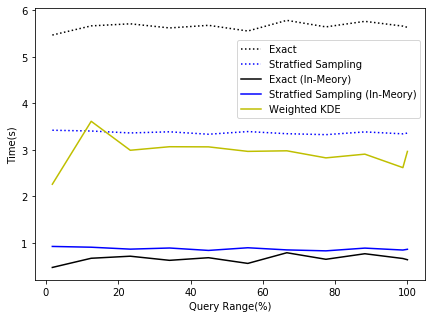

In [99]:
# Time
plt.figure(figsize=(7, 5))
plt.plot(query_range, 5 + np.array(runtime)[:,2], 'k:', label='Exact')
plt.plot(query_range, 2.5 + np.array(runtime)[:,1], 'b:', label='Stratfied Sampling')
plt.plot(query_range, np.array(runtime)[:,2], 'k', label='Exact (In-Meory)')
plt.plot(query_range, np.array(runtime)[:,1], 'b', label='Stratfied Sampling (In-Meory)')
plt.plot(query_range, np.array(runtime)[:,0], 'y' , label='Weighted KDE')

plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0.4, 0.4))
plt.xlabel('Query Range(%)')
plt.ylabel('Time(s)')

plt.savefig('./figs/time_selectivity.png')

### How does the predicate selectivity influence the error?

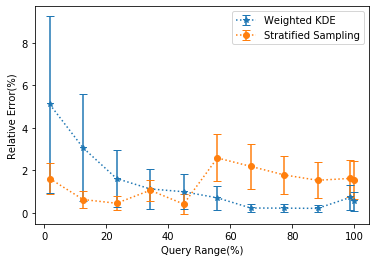

In [45]:
# Error
plt.figure(figsize=(6, 4))
plt.errorbar(query_range, [mean for mean, std, _ , _ in error_bank], yerr=[std for mean, std,  _ , _ in error_bank],\
             fmt='*:', capsize=4, label='Weighted KDE')
plt.errorbar(query_range, [mean for  _ , _ , mean, std in error_bank], yerr=[std for _ , _,mean, std in error_bank],\
             fmt='o:', capsize=4, label='Stratified Sampling')
plt.legend()
plt.xlabel('Query Range(%)')
plt.ylabel('Relative Error(%)')
plt.savefig('./figs/error_selectivity.png')

# 5.2. Effect of Kernel Bandwidth

In [112]:
def impact_of_bandwidth(bw_plot, d):
    error_bank, runtime = [], []
    for bw in bw_plot:
        left_date = date(1998, 12, 1) - timedelta(days = d)
        right_date= date(1998, 12, 1) + timedelta(days = d)
        
        
        # Construction
#         start = timeit.default_timer()
#         strata_catalogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
#         strata_catalogue = strata_catalogue.cache(); strata_catalogue.count()
#         stop = timeit.default_timer(); construction_time = stop - start
        
        # Execution time
        start = timeit.default_timer()
        Q1_kde_approx = kde_based_method_testing(strata_catalogue, left_date, right_date, bw).cache(); Q1_kde_approx.count()
        stop = timeit.default_timer(); estimation_time = stop - start
        
        # Exact query 
        start = timeit.default_timer()
        Q1_exact = compute_exact_result(lineitem, left_date, right_date); Q1_exact.count()
        stop = timeit.default_timer(); exact_time = stop - start
        
        # Store performace
#         runtime.append([construction_time, estimation_time, exact_time])
        runtime.append([estimation_time, exact_time])
        error_bank.append((calculate_error(Q1_kde_approx, Q1_exact).mean().mean(), calculate_error(Q1_kde_approx, Q1_exact).mean().std()))
    return error_bank, runtime

### Effect of bandwidth on a large predicate length (2000). 
A small kernel width provides a model of higher resolution.

In [50]:
bw_plot = np.linspace(.01, .6, 10)
error_bank_bw_large, runtime_bw_large = impact_of_bandwidth(bw_plot, 2000)

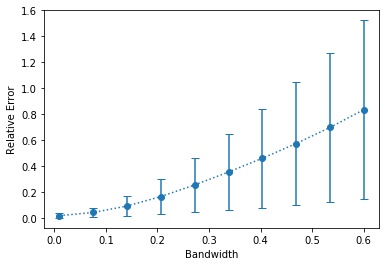

In [53]:
# Error
plt.figure(figsize=(6, 4))
plt.errorbar(bw_plot, [mean for mean, std in error_bank_bw_large], fmt="o:", \
             yerr=[std for mean, std in error_bank_bw_large], capsize=4)
plt.xlabel('Bandwidth')
plt.ylabel('Relative Error')
plt.savefig('./figs/error_bw_2000.png')

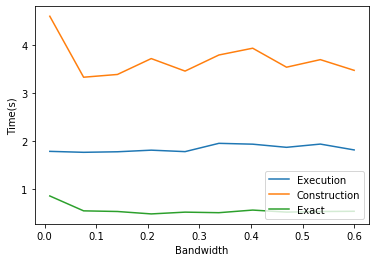

In [54]:
plt.figure(figsize=(6, 4))
plt.plot(bw_plot, np.array(runtime_bw_large)[:,1], label='Execution')
plt.plot(bw_plot, np.array(runtime_bw_large)[:,0], label='Construction')
plt.plot(bw_plot, np.array(runtime_bw_large)[:,2], label='Exact')
plt.legend(loc=4)
plt.xlabel('Bandwidth')
plt.ylabel('Time(s)')
# plt.savefig('./figs/time_bw_2000.png')

### Effect of bandwidth on a samll predicate length (10). 
A small kernel width provides a model of higher resolution.

In [56]:
error_bank_bw_small, runtime_bw_small = impact_of_bandwidth(bw_plot, 100)

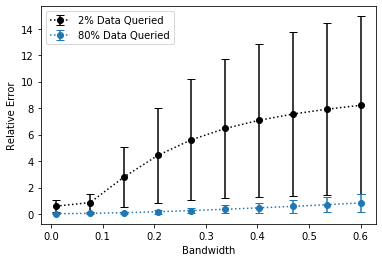

In [106]:
# Error
plt.figure(figsize=(6, 4))
plt.errorbar(bw_plot, [mean for mean, std in error_bank_bw_small], fmt="ko:", \
             yerr=[std for mean, std in error_bank_bw_small], capsize=4, label = '2% Data Queried')
plt.errorbar(bw_plot, [mean for mean, std in error_bank_bw_large], fmt="o:", \
             yerr=[std for mean, std in error_bank_bw_large], capsize=4, label = '80% Data Queried')
plt.xlabel('Bandwidth')
plt.ylabel('Relative Error')
plt.legend(loc=2)
plt.savefig('./figs/error_bw.jpg')

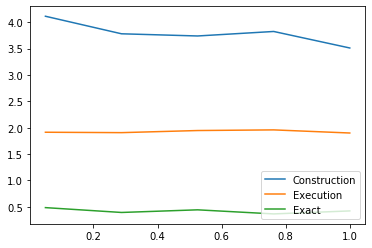

In [127]:
plt.figure(figsize=(6, 4))
plt.plot(bw_plot, np.array(runtime_bw)[:,0], label='Construction')
plt.plot(bw_plot, np.array(runtime_bw)[:,1], label='Execution')
plt.plot(bw_plot, np.array(runtime_bw)[:,2], label='Exact')
plt.legend(loc=4)
plt.xlabel('Bandwidth')
plt.ylabel('Time(s)')
plt.savefig('./figs/time_bw_10.jpg')

## Effect of very samll bandwidth 

Text(0, 0.5, 'Relative Error')

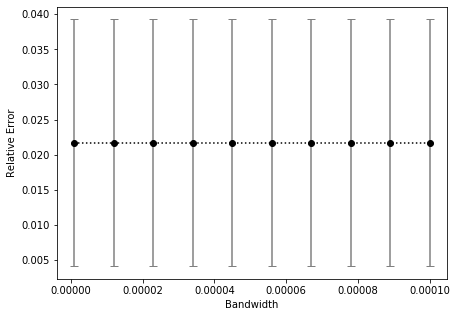

In [120]:
bw_plot = np.linspace(.000001, .0001, 10)
error_bank_bw, runtime_bw = impact_of_bandwidth(bw_plot, 2000)

# Error
plt.figure(figsize=(7, 5))
plt.errorbar(bw_plot, [mean for mean, std in error_bank_bw], fmt="ko:", \
             yerr=[std for mean, std in error_bank_bw], capsize=4, ecolor='grey')
plt.xlabel('Bandwidth')
plt.ylabel('Relative Error')
# plt.savefig('./figs/time_bw_100.jpg')

Text(0, 0.5, 'Time(s)')

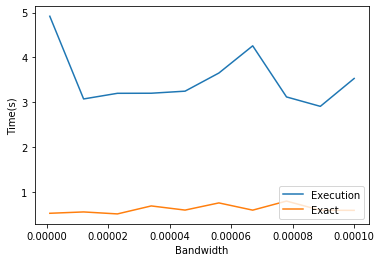

In [121]:
plt.figure(figsize=(6, 4))
# plt.plot(bw_plot, np.array(runtime_bw)[:,0], label='Construction')
plt.plot(bw_plot, np.array(runtime_bw)[:,0], label='Execution')
plt.plot(bw_plot, np.array(runtime_bw)[:,1], label='Exact')
plt.legend(loc=4)
plt.xlabel('Bandwidth')
plt.ylabel('Time(s)')
# plt.savefig('./figs/time_bw_100.jpg')